# Setup


## Imports


In [1]:
import os

In [2]:
import numpy as np
import scipy
from scipy.stats import binned_statistic, binned_statistic_2d
import pandas as pd

In [3]:
import matplotlib
from matplotlib import patheffects
import matplotlib.pyplot as plt
import seaborn as sns

## Parameters


In [4]:
config = {
    "dir": "../../outputs/librarian=S2",
    "bins": 16,
    "min_bin_percentile": 1,
    "min_bin_percentile_for_cpy": 10,
    "min_diff": 2,
    "left_density": "SciBERT",
    "right_density": "Word2Vec",
}

# Data Preprocessing


In [5]:
# Ensure we don't have any old dataframes
try:
    del df_combined
except NameError:
    pass
# Main loop
for i, vectorizer_dir in enumerate(os.listdir(config["dir"])):

    # Combine same vectorizer, different centers
    dfs = []
    for j, center_dir in enumerate(
        os.listdir(os.path.join(config["dir"], vectorizer_dir))
    ):
        # Open
        fp = os.path.join(config["dir"], vectorizer_dir, center_dir, "all_data.csv")
        df = pd.read_csv(fp)

        # Skip dfs with no identifier
        try:
            df = df.set_index("identifier")
        except KeyError:
            continue

        # Add df to list
        dfs.append(df)

    # Combine across centers
    if len(dfs) == 0:
        continue
    df = pd.concat(dfs)

    # Rename columns
    vectorizer = vectorizer_dir.split("=")[-1]
    for col in ["density", "edginess"]:
        df[f"{col}_{vectorizer}"] = df[col]
        del df[col]

    # Combine across vectorizers
    try:
        df_combined = df_combined.join(
            df.drop(columns=["citations_per_year", "year", "references", "is_center"]),
            how="left",
        )
    except NameError:
        df_combined = df

/var/folders/54/sj990qts6dl73m0p_445j_900000gq/T/ipykernel_96605/1718358525.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(dfs)


In [6]:
# Drop rows with missing data or duplicates
df_combined = df_combined.dropna(
    axis="index",
    how="any",
    subset=[f"density_{config['left_density']}", f"density_{config['right_density']}"],
)
df_combined = df_combined.loc[~df_combined.index.duplicated()]

In [7]:
# Calculate percentiles for density vars
quantiles = np.linspace(0, 1, config["bins"] + 1)
density_vars = [var for var in df_combined.columns if "density" in var]
density_bins = {}
for var in density_vars:

    # Get density
    density = df_combined[var].values

    # Get density bins
    bins = np.linspace(
        np.nanpercentile(density, config["min_bin_percentile"]),
        np.nanpercentile(density, 100 - config["min_bin_percentile"]),
        config["bins"],
    )
    density_bins[var] = bins

    # Calculate and use quantile bins
    vectorizer = var.split("_")[-1]
    bins = np.quantile(density, quantiles)
    df_combined.loc[:, f"bin_{vectorizer}"] = np.digitize(density, bins=bins)

In [8]:
# Isolate entries where the density differs by >= min_diff bin
df_combined["different_densities"] = (
        np.abs(df_combined[f"bin_{config["left_density"]}"] -
               df_combined[f"bin_{config["right_density"]}"])
    ) >= config["min_diff"]
df_combined["different_densities"].value_counts()

different_densities
True     65066
False    18699
Name: count, dtype: int64

# Visualization


## Pairwise histograms

In [9]:
def hist(x, **kwargs):
    bins = density_bins[x.name]
    sns.histplot(x, bins=bins, **kwargs)
    plt.xlim(bins[0], bins[-1])

In [10]:
def hist2d(x, y, **kwargs):
    x_bins = density_bins[x.name]
    y_bins = density_bins[y.name]
    sns.histplot(x=x, y=y, bins=(x_bins, y_bins), **kwargs)
    plt.xlim(x_bins[0], x_bins[-1])
    plt.ylim(y_bins[0], y_bins[-1])

/Users/Shared/miniconda3/envs/llm/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Shared/miniconda3/envs/llm/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Shared/miniconda3/envs/llm/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/Shared/miniconda3/envs/llm/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

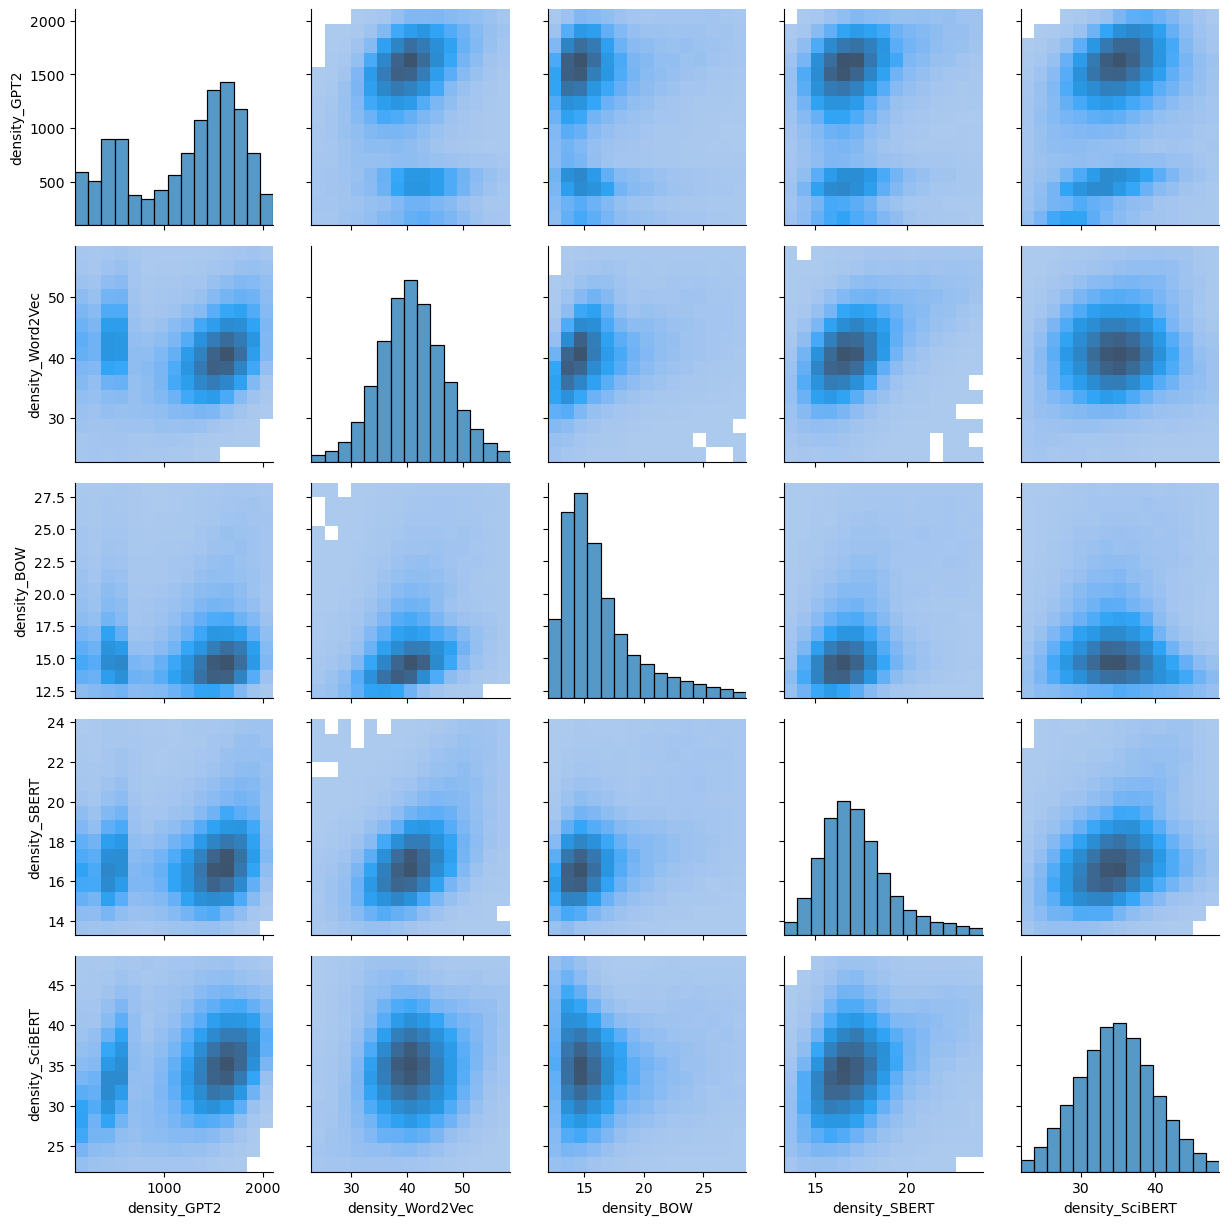

In [11]:
# Basic visualization
g = sns.PairGrid(df_combined, vars=density_vars)
g.map_diag(hist)
g.map_offdiag(hist2d)

## Vs Citations

In [12]:
cpy_bins = np.linspace(
    np.nanpercentile(
        df_combined["citations_per_year"].dropna(), config["min_bin_percentile_for_cpy"]
    ),
    np.nanpercentile(
        df_combined["citations_per_year"].dropna(),
        100 - config["min_bin_percentile_for_cpy"],
    ),
    config["bins"],
)
cpy_median = df_combined["citations_per_year"].median()

In [13]:
def cpy_vs_density(x, **kwargs):

    ax = plt.gca()

    bins = density_bins[x.name]
    centers = (bins[1:] + bins[:-1]) / 2

    # Calculate running median
    median, bin_edges, bin_number = binned_statistic(
        x, df_combined["citations_per_year"], statistic="median", bins=bins
    )
    ax.plot(
        centers,
        median,
        color="k",
    )

    # Calculate running percentiles
    low, bin_edges, bin_number = binned_statistic(
        x,
        df_combined["citations_per_year"],
        statistic=lambda v: np.nanpercentile(v, 16),
        bins=bins,
    )
    high, bin_edges, bin_number = binned_statistic(
        x,
        df_combined["citations_per_year"],
        statistic=lambda v: np.nanpercentile(v, 84),
        bins=bins,
    )
    ax.fill_between(
        centers,
        low,
        high,
        color="k",
        alpha=0.1,
    )

    ax.set_xlim(bins[0], bins[-1])

In [14]:
def median_cpy(x, y, **kwargs):

    x_bins = density_bins[x.name]
    y_bins = density_bins[y.name]

    def _excess_above_median(z):

        return (z > cpy_median).sum() - z.size / 2

    statistic, x_edges, y_edges, binnumber = binned_statistic_2d(
        x,
        y,
        df_combined["citations_per_year"],
        bins=[x_bins, y_bins],
        statistic=_excess_above_median,
    )

    ax = plt.gca()

    ax.pcolormesh(
        x_edges,
        y_edges,
        statistic.T,
        shading="auto",
        vmin=-df_combined.shape[0] / 2 / config["bins"] ** 2,
        vmax=df_combined.shape[0] / 2 / config["bins"] ** 2,
        cmap=sns.color_palette("vlag", as_cmap=True),
        linewidth=0.0001,
        **kwargs,
    )

    ax.set_xlim(x_bins[0], x_bins[-1])
    ax.set_ylim(y_bins[0], y_bins[-1])


In [15]:
sns.set_style("white")

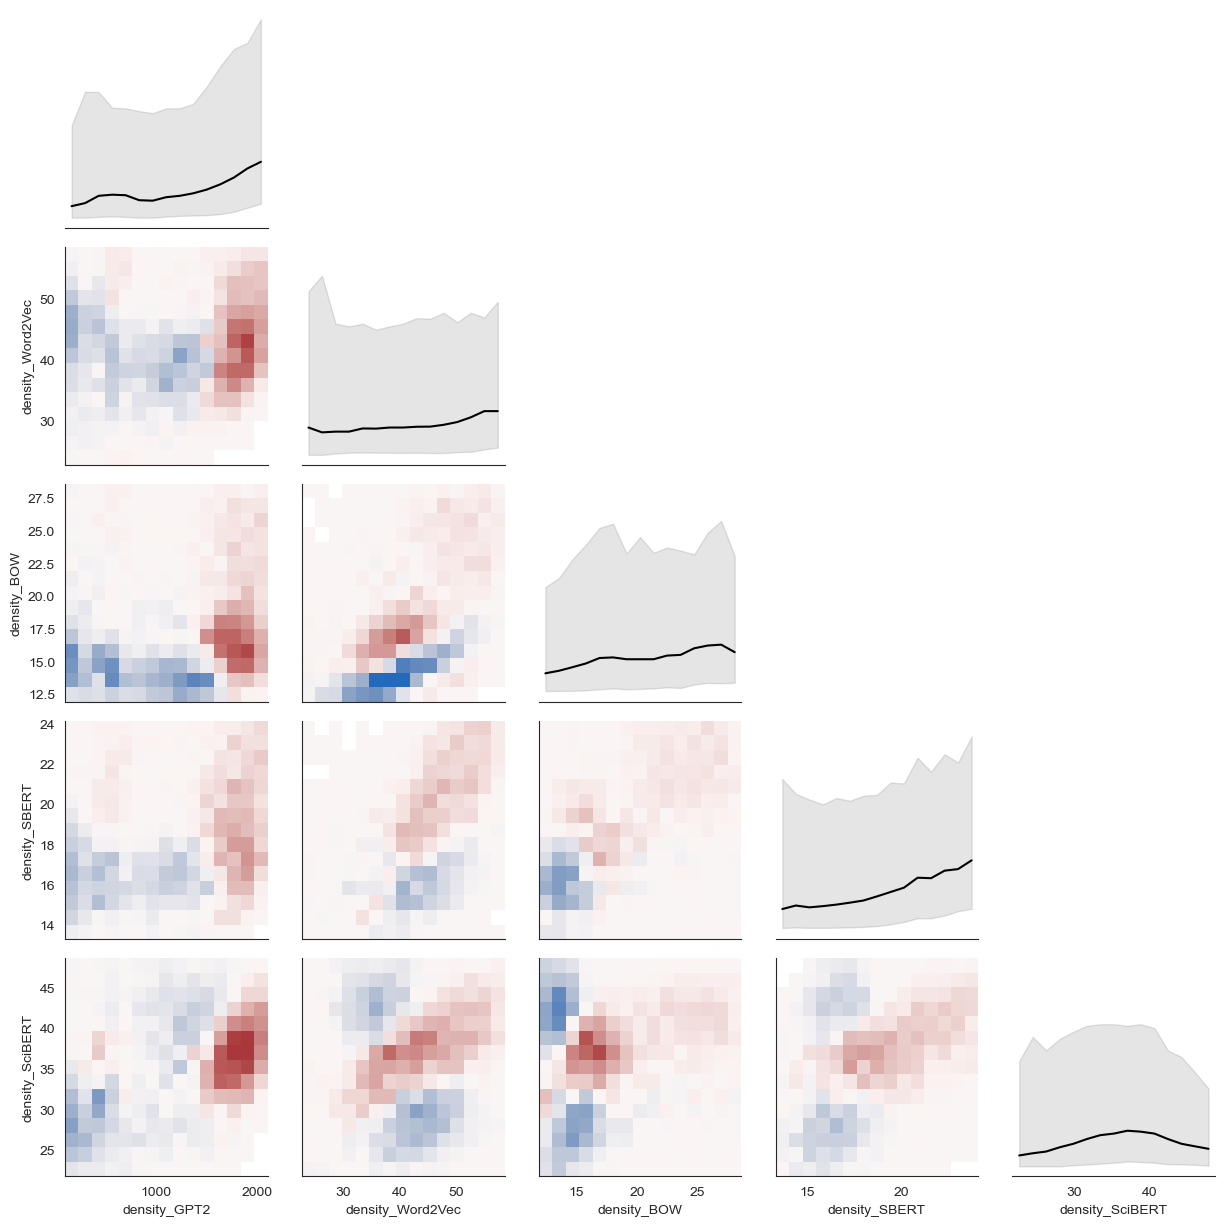

In [16]:
# Basic visualization
g = sns.PairGrid(df_combined, vars=density_vars, corner=True)
g.map_diag(cpy_vs_density)
g.map_offdiag(median_cpy)
g